In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kagglexfellowship/kagglex-cohort4/sample_submission.csv
/kaggle/input/kagglexfellowship/kagglex-cohort4/train.csv
/kaggle/input/kagglexfellowship/kagglex-cohort4/test.csv


In [2]:
#  Import and read the data and assign ID column as labels
train = pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/train.csv')
test=pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/test.csv')
subm=pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/sample_submission.csv')


In [3]:
#Drop the non-beneficial ID columns
def set_index (df):
    df.set_index('id', inplace=True)
    return df

train_df=set_index(train)
test_df=set_index(test)
submission_df=set_index(subm)


# Data Exploration

In [4]:
#Determine the number of unique values in each column.
unique_counts = train_df.nunique()
unique_counts

brand             53
model           1827
model_year        34
milage          3212
fuel_type          7
engine          1061
transmission      46
ext_col          260
int_col          124
accident           2
clean_title        1
price           1481
dtype: int64

In [5]:
# Checking the datatypes
train_df.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [6]:
train_df.shape

(54273, 12)

In [7]:
#Lets look for the total number of NaN values for each feature
train_df.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


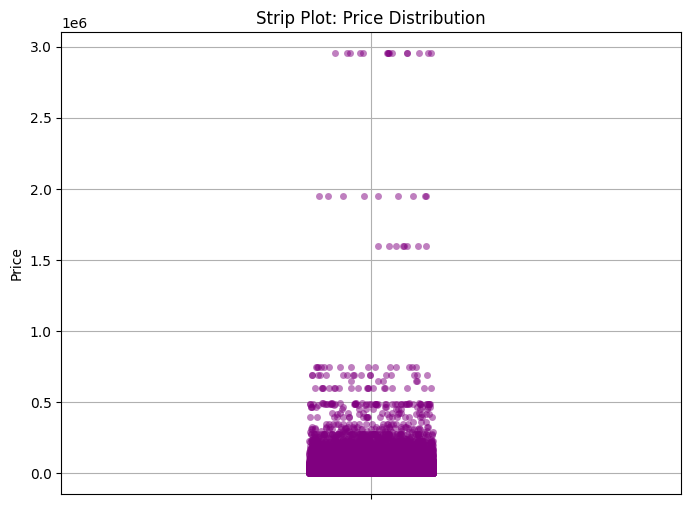

In [8]:
# Create a strip plot for the 'price' variable
plt.figure(figsize=(8, 6))
sns.stripplot(data=train_df, y='price', jitter=True, color='purple', alpha=0.5)
plt.title('Strip Plot: Price Distribution')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Above Histogram shows that most cars lie in the lower range of price.
The above graph has outliers from 0.4 onwards, which need to be removed.

In [9]:
train_df['price'].describe()

count    5.427300e+04
mean     3.921844e+04
std      7.282634e+04
min      2.000000e+03
25%      1.550000e+04
50%      2.800000e+04
75%      4.500000e+04
max      2.954083e+06
Name: price, dtype: float64

In [10]:
#identify and remove outliers from the data df in relation to price column using IQR method
Q1 = train_df['price'].quantile(0.25)
Q3 = train_df['price'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

29500.0


In [11]:
#use IQR value to filter out the outliers
outliersfree_df = train_df[~((train_df['price'] < (Q1 - 1.5 * IQR)) |(train_df['price'] > (Q3 + 0.7 * IQR)))]
outliersfree_df.shape

(47678, 12)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


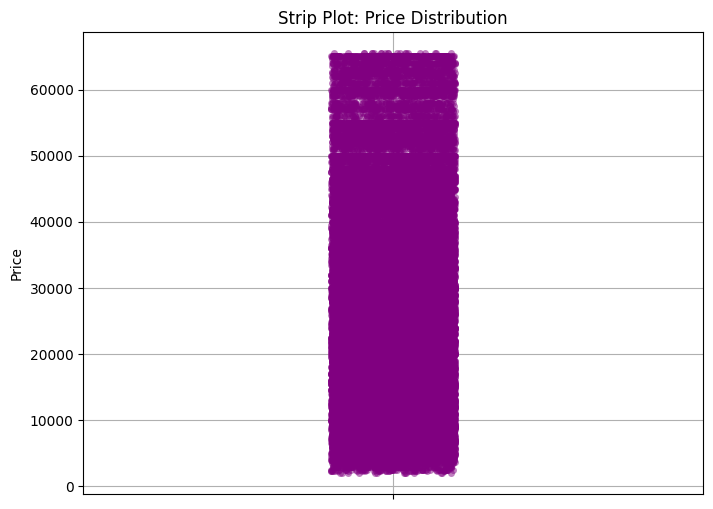

In [12]:
plt.figure(figsize=(8, 6))
sns.stripplot(data=outliersfree_df, y='price', jitter=True, color='purple', alpha=0.5)
plt.title('Strip Plot: Price Distribution')
plt.ylabel('Price')
plt.grid(True)
plt.show()

The above plot looks more homogeneous than the previous one after removal of outliers.

# **Data wrangling**

I will reduce the number of features in string data categories, and will remain the numeric categories as they are.

In [13]:
#Look at brand value counts for binning
brand_counts = outliersfree_df['brand'].value_counts()
brand_counts #keep all car brands 

brand
BMW              6331
Ford             6008
Mercedes-Benz    4118
Chevrolet        3829
Audi             2676
Toyota           2177
Jeep             2138
Lexus            2121
Porsche          1805
Land             1567
Cadillac         1387
Nissan           1179
GMC               972
Dodge             932
INFINITI          904
RAM               883
Mazda             737
Subaru            727
Lincoln           724
Hyundai           687
Honda             620
Volkswagen        617
Jaguar            590
Acura             559
Kia               498
Volvo             429
MINI              360
Chrysler          253
Maserati          243
Buick             219
Genesis           211
Mitsubishi        179
Hummer            175
Pontiac           146
Alfa              130
Bentley           127
Tesla              93
Saturn             58
Rolls-Royce        53
Scion              52
Lamborghini        42
McLaren            20
Aston              20
Mercury            20
Ferrari            19
FIAT

***Model cleaning***

In [14]:
# Look at model value counts for binning
model_counts =outliersfree_df['model'].value_counts()
model_counts

model
F-150 XLT                733
M3 Base                  610
X5 xDrive35i             590
F-150 Lariat             451
Mustang GT Premium       440
                        ... 
Suburban 2500              1
G-Class G 63 AMG           1
Rover Range Rover SWB      1
RDX w/A-Spec Package       1
S-10 LS                    1
Name: count, Length: 1795, dtype: int64

In [15]:
#Reducing the number of car models as a fuature
cutoff_value = 100 #keep if database has 100 and more records of this car model
model_types_to_replace = model_counts[model_counts < cutoff_value].index

# Replace in the dataframe
for model_c in model_types_to_replace:
    outliersfree_df.loc[outliersfree_df['model'] == model_c, 'model'] = "Other"

# Check the updated value counts
model_counts = outliersfree_df['model'].value_counts()
print(model_counts)

model
Other                      30231
F-150 XLT                    733
M3 Base                      610
X5 xDrive35i                 590
F-150 Lariat                 451
                           ...  
335 i xDrive                 103
Sequoia Limited              100
Golf GTI 2.0T SE 4-Door      100
Civic EX                     100
Cayman Base                  100
Name: count, Length: 94, dtype: int64


**Fuel cleaning**

In [16]:
# Look at fuel value counts for binning
fuel_counts = outliersfree_df['fuel_type'].value_counts()
fuel_counts

fuel_type
Gasoline          43613
E85 Flex Fuel      1435
Hybrid             1323
Diesel              889
–                   266
Plug-In Hybrid      148
not supported         4
Name: count, dtype: int64

In [17]:
# Replace '–' with 'Other' in the 'fuel_type' column
outliersfree_df.loc[outliersfree_df['fuel_type'] == '–', 'fuel_type'] = 'Other'
cleaned_train = outliersfree_df[outliersfree_df['fuel_type'] != 'not supported']
fuel_counts = cleaned_train['fuel_type'].value_counts()
fuel_counts

fuel_type
Gasoline          43613
E85 Flex Fuel      1435
Hybrid             1323
Diesel              889
Other               266
Plug-In Hybrid      148
Name: count, dtype: int64

***Engine cleaning***

In [18]:
# Look at endine value counts for binning
engine_counts = cleaned_train['engine'].value_counts()
engine_counts

engine
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    1411
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel             1067
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel             1044
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel             924
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel              689
                                                         ... 
290.0HP Electric Motor Electric Fuel System                 1
3.6L V6 24V MPFI DOHC Hybrid                                1
3.0 Liter SC ULEV                                           1
483.0HP 4.3L 8 Cylinder Engine Gasoline Fuel                1
3.2L V6 24V MPFI DOHC                                       1
Name: count, Length: 1043, dtype: int64

In [19]:
cutoff_value = 100
engine_types_to_replace = engine_counts[engine_counts < cutoff_value].index

# Replace in the dataframe
for engine_c in engine_types_to_replace:
    cleaned_train.loc[cleaned_train['engine'] == engine_c, 'engine'] = "Other"

# Check the updated value counts
engine_counts = cleaned_train['engine'].value_counts()
engine_counts

engine
Other                                                    20309
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel     1411
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel              1067
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel              1044
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel              924
                                                         ...  
280.0HP 3.6L V6 Cylinder Engine Gasoline Fuel              105
300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel               103
188.0HP 3.0L V6 Cylinder Engine Diesel Fuel                103
310.0HP 3.0L V6 Cylinder Engine Gasoline Fuel              102
518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel               102
Name: count, Length: 106, dtype: int64

***Transmission***

In [20]:
# Look at trans value counts for binning
trans_counts = cleaned_train['transmission'].value_counts()
trans_counts

transmission
A/T                                                   15558
8-Speed A/T                                            5804
6-Speed A/T                                            5791
Transmission w/Dual Shift Mode                         5284
6-Speed M/T                                            3384
7-Speed A/T                                            2786
10-Speed A/T                                           1603
5-Speed A/T                                            1171
8-Speed Automatic                                       953
9-Speed A/T                                             805
4-Speed A/T                                             739
5-Speed M/T                                             711
CVT Transmission                                        680
10-Speed Automatic                                      519
6-Speed Automatic                                       483
Automatic                                               357
M/T                        

In [21]:
cutoff_value = 10
trans_types_to_replace = trans_counts[trans_counts < cutoff_value].index

# Replace in the dataframe
for trans_c in trans_types_to_replace:
    cleaned_train.loc[cleaned_train['transmission'] == trans_c, 'transmission'] = "Other"

# Check the updated value counts
trans_counts = cleaned_train['transmission'].value_counts()
trans_counts

transmission
A/T                                  15558
8-Speed A/T                           5804
6-Speed A/T                           5791
Transmission w/Dual Shift Mode        5284
6-Speed M/T                           3384
7-Speed A/T                           2786
10-Speed A/T                          1603
5-Speed A/T                           1171
8-Speed Automatic                      953
9-Speed A/T                            805
4-Speed A/T                            739
5-Speed M/T                            711
CVT Transmission                       680
10-Speed Automatic                     519
6-Speed Automatic                      483
Automatic                              357
M/T                                    339
9-Speed Automatic                      279
Automatic CVT                           91
Transmission Overdrive Switch           53
7-Speed Automatic with Auto-Shift       53
7-Speed M/T                             46
1-Speed A/T                             4

***External colour***

In [22]:
# Look at colours value counts for binning
ext_col_counts = cleaned_train['ext_col'].value_counts()
ext_col_counts.head(50)

ext_col
Black                                 13237
White                                 12006
Gray                                   6605
Silver                                 4751
Blue                                   4156
Red                                    2699
Green                                   565
Gold                                    463
Beige                                   433
Brown                                   364
Yellow                                  277
Orange                                  243
Agate Black Metallic                    105
Bright White Clearcoat                   99
Purple                                   90
Black Clearcoat                          77
Summit White                             71
Diamond Black                            59
Silver Ice Metallic                      57
Delmonico Red Pearlcoat                  51
Soul Red Crystal Metallic                45
Snowflake White Pearl                    32
Ebony Twilight Metallic 

In [23]:
cutoff_value = 20
ext_col_types_to_replace = ext_col_counts[ext_col_counts < cutoff_value].index

# Replace in the dataframe
for ext_col_c in ext_col_types_to_replace:
    cleaned_train.loc[cleaned_train['ext_col'] == ext_col_c, 'ext_col'] = "Other"

# Check the updated value counts
ext_col_counts = cleaned_train['ext_col'].value_counts()
ext_col_counts

ext_col
Black                        13237
White                        12006
Gray                          6605
Silver                        4751
Blue                          4156
Red                           2699
Other                          983
Green                          565
Gold                           463
Beige                          433
Brown                          364
Yellow                         277
Orange                         243
Agate Black Metallic           105
Bright White Clearcoat          99
Purple                          90
Black Clearcoat                 77
Summit White                    71
Diamond Black                   59
Silver Ice Metallic             57
Delmonico Red Pearlcoat         51
Soul Red Crystal Metallic       45
Snowflake White Pearl           32
Jet Black Mica                  27
Ebony Twilight Metallic         27
Firecracker Red Clearcoat       25
Sonic Silver Metallic           23
Cajun Red Tintcoat              22
Black Sapphi

In [24]:
# Look at colours value counts for binning
int_col_counts = cleaned_train['int_col'].value_counts()
int_col_counts.head(50)

int_col
Black                         27600
Beige                          7582
Gray                           5901
Brown                          1838
Red                            1182
–                               935
White                           892
Jet Black                       306
Ebony                           201
Orange                          173
Blue                            147
Silver                          100
Gold                             89
Green                            46
Global Black                     44
Medium Stone                     36
Charcoal                         31
Diesel Gray / Black              26
Rioja Red                        25
Black Onyx                       22
Medium Dark Slate                22
White / Brown                    22
Graphite                         20
Light Slate                      17
Medium Earth Gray                17
Shara Beige                      16
Canberra Beige                   14
Medium Light Camel  

In [25]:
cleaned_train.loc[cleaned_train['int_col'] == '–', 'int_col'] = 'Other'

In [26]:
cutoff_value = 10
int_col_types_to_replace = int_col_counts[int_col_counts < cutoff_value].index

# Replace in the dataframe
for int_col_c in int_col_types_to_replace:
    cleaned_train.loc[cleaned_train['int_col'] == int_col_c, 'int_col'] = "Other"

# Check the updated value counts
int_col_counts = cleaned_train['int_col'].value_counts()
int_col_counts

int_col
Black                    27600
Beige                     7582
Gray                      5901
Brown                     1838
Other                     1202
Red                       1182
White                      892
Jet Black                  306
Ebony                      201
Orange                     173
Blue                       147
Silver                     100
Gold                        89
Green                       46
Global Black                44
Medium Stone                36
Charcoal                    31
Diesel Gray / Black         26
Rioja Red                   25
White / Brown               22
Medium Dark Slate           22
Black Onyx                  22
Graphite                    20
Light Slate                 17
Medium Earth Gray           17
Shara Beige                 16
Canberra Beige              14
Ceramic                     13
Deep Chestnut               13
Medium Light Camel          13
Sandstone                   12
Tan                         11


In [27]:
# Determine the cleaned number of unique values in each column.
unique_counts = cleaned_train.nunique()
unique_counts

brand             51
model             94
model_year        34
milage          3093
fuel_type          6
engine           106
transmission      29
ext_col           32
int_col           36
accident           2
clean_title        1
price           1108
dtype: int64

In [28]:
#The last column "Clean_title" is the same "Yes" answer for all rows, that gives no value to analysis. 
#Drop this column.
final_train=cleaned_train.drop(columns=['clean_title'])


In [29]:
# Display the value counts for each column
for column in final_train.columns:
    value_counts = final_train[column].value_counts()
    print(value_counts)


brand
BMW              6331
Ford             6008
Mercedes-Benz    4118
Chevrolet        3829
Audi             2676
Toyota           2174
Jeep             2138
Lexus            2121
Porsche          1805
Land             1567
Cadillac         1387
Nissan           1178
GMC               972
Dodge             932
INFINITI          904
RAM               883
Mazda             737
Subaru            727
Lincoln           724
Hyundai           687
Honda             620
Volkswagen        617
Jaguar            590
Acura             559
Kia               498
Volvo             429
MINI              360
Chrysler          253
Maserati          243
Buick             219
Genesis           211
Mitsubishi        179
Hummer            175
Pontiac           146
Alfa              130
Bentley           127
Tesla              93
Saturn             58
Rolls-Royce        53
Scion              52
Lamborghini        42
McLaren            20
Aston              20
Mercury            20
Ferrari            19
FIAT

***Liner Regression***

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
# Convert categorical data to numeric with `pd.get_dummies`
X = pd.get_dummies(final_train)
X.shape


(47674, 359)

In [32]:
# Split our preprocessed data into our features and target arrays
y=X['price'].values.reshape(-1, 1)

In [33]:
#Removing the price from the prediction features
X = X.drop(['price'], axis=1)


In [34]:
lm = LinearRegression()
lm.fit(X,y)

LinearRegression()

In [35]:
#make predictions
yhat = lm.predict(X)
yhat[0:5]

array([[41478.50668335],
       [15646.14181519],
       [16779.60705566],
       [51436.94760132],
       [ 8594.50393677]])

In [36]:
#find the intercept
lm.intercept_

array([-5.78806342e+10])

In [37]:
#find the slope
lm.coef_

array([[ 1.04101121e+03, -9.14066169e-02,  5.84567407e+09,
         5.84567505e+09,  5.84568304e+09,  5.84567819e+09,
         5.84567821e+09,  5.84568112e+09,  5.84567410e+09,
         5.84567498e+09,  5.84567648e+09,  5.84567185e+09,
         5.84567747e+09,  5.84566276e+09,  5.84567719e+09,
         5.84567775e+09,  5.84567416e+09,  5.84567705e+09,
         5.84567472e+09,  5.84567595e+09,  5.84567034e+09,
         5.84567549e+09,  5.84567664e+09,  5.84567532e+09,
         5.84567178e+09,  5.84567836e+09,  5.84567731e+09,
         5.84567704e+09,  5.84567577e+09,  5.84568672e+09,
         5.84567010e+09,  5.84567890e+09,  5.84571338e+09,
         5.84567207e+09,  5.84568160e+09,  5.84568067e+09,
         5.84568057e+09,  5.84567180e+09,  5.84567407e+09,
         5.84566212e+09,  5.84567739e+09,  5.84568110e+09,
         5.84568040e+09,  5.84567911e+09,  5.84569007e+09,
         5.84567450e+09,  5.84566869e+09,  5.84567214e+09,
         5.84566721e+09,  5.84568089e+09,  5.84567739e+0

In [38]:
#find the MSE
from sklearn.metrics import mean_squared_error

# Calculate the mean squared error
mse = mean_squared_error(y, yhat)

# Print the MSE
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 93163025.59848437


In [39]:
#find the RMSE
rmse = np.sqrt(mse)
rmse

9652.099543544107

In [40]:
#find rscore
from sklearn.metrics import r2_score
r2_score(y, yhat)

0.6073775536095762

# Validation with test data

In [41]:
test_df


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
id,,,,,,,,,,,
54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes
54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Silver,Black,None reported,Yes
54275,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Blue,White,None reported,Yes
54276,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,White,At least 1 accident or damage reported,Yes
54277,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes
...,...,...,...,...,...,...,...,...,...,...,...
90451,GMC,Yukon Denali,2019,4500,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Gray,Black,None reported,Yes
90452,Chevrolet,Silverado 1500 Z71 Extended Cab,2004,185000,Gasoline,295.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,4-Speed A/T,Red,Gray,At least 1 accident or damage reported,Yes
90453,Toyota,Corolla LE,2011,116000,Gasoline,132.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,Beige,Gray,None reported,Yes


In [42]:
submission_df

,price
id,
54273,39218.443
54274,39218.443
54275,39218.443
54276,39218.443
54277,39218.443
...,...
90451,39218.443
90452,39218.443
90453,39218.443
